In [1]:
from importlib import reload

In [2]:
import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.nddata import utils as ndutils

In [3]:
from photutils import psf
reload(psf)

<module 'photutils.psf' from '/Users/erik/src/photutils/photutils/psf.py'>

In [4]:
%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get "real" images
rcParams['figure.figsize'] = (15,10)

# First load the tinytim PSFs for ACS/WFC

In [5]:
ls psf_acswf606w

composite.png            logfile.txt              result00_02.png          result00_cuts.dat        result00_psf_05.png
figurepage.html          output.txt               result00_03.png          result00_energy.dat      result00_psf_06.png
footer_tinytimweb.php    parameters.txt*          result00_04.png          result00_psf.fits        result00_psf_07.png
header_tinytimweb.php    process.txt*             result00_05.png          result00_psf_01.png      result00_psf_08.png
index.html               result.tt3               result00_06.png          result00_psf_02.png      result00_psf_cuts.dat
index.php.save           result00.fits            result00_07.png          result00_psf_03.png      result00_psf_energy.dat
input.txt*               result00_01.png          result00_08.png          result00_psf_04.png


In [6]:
f606psf = fits.getdata('psf_acswf606w/result00.fits')
f814psf = fits.getdata('psf_acswf814w/result00.fits')

/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


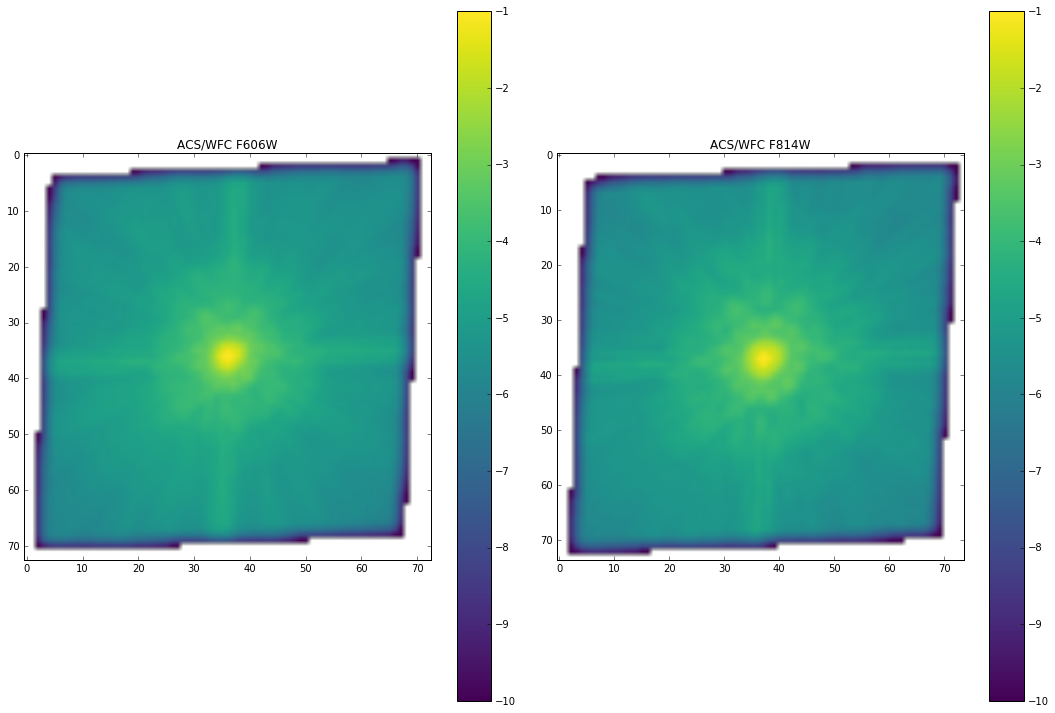

In [7]:
plt.subplot(1,2,1)
plt.imshow(np.log10(f606psf), vmin=-10, vmax=-1)
plt.title('ACS/WFC F606W')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.log10(f814psf), vmin=-10, vmax=-1)
plt.title('ACS/WFC F814W')
plt.colorbar()
plt.tight_layout()

## F606W interp

In [8]:
psf_indecies = np.indices(f606psf.shape) - f606psf.shape[0]//2
psf_indecies_1d = psf_indecies[1,0]

interp606 = interpolate.RectBivariateSpline(psf_indecies_1d, psf_indecies_1d, f606psf)

/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


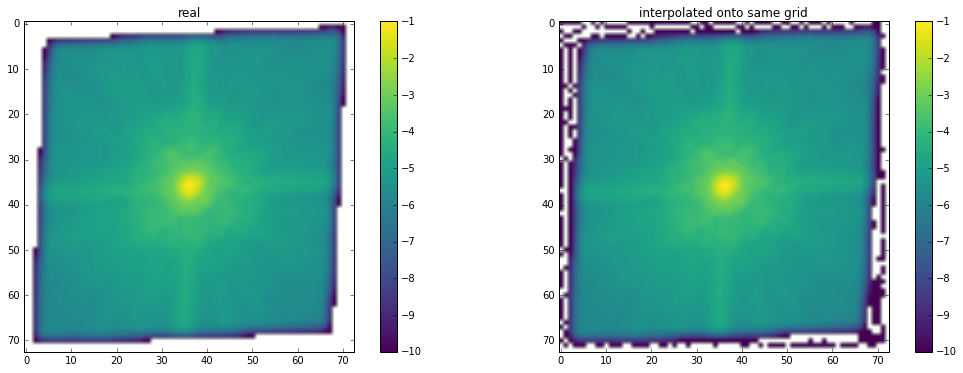

In [9]:
plt.subplot(2,2,1)
plt.imshow(np.log10(f606psf), vmin=-10, vmax=-1)
plt.title('real')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.log10(interp606(*psf_indecies, grid=False)),vmin=-10, vmax=-1)
plt.title('interpolated onto same grid')
plt.colorbar()
plt.tight_layout()

/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


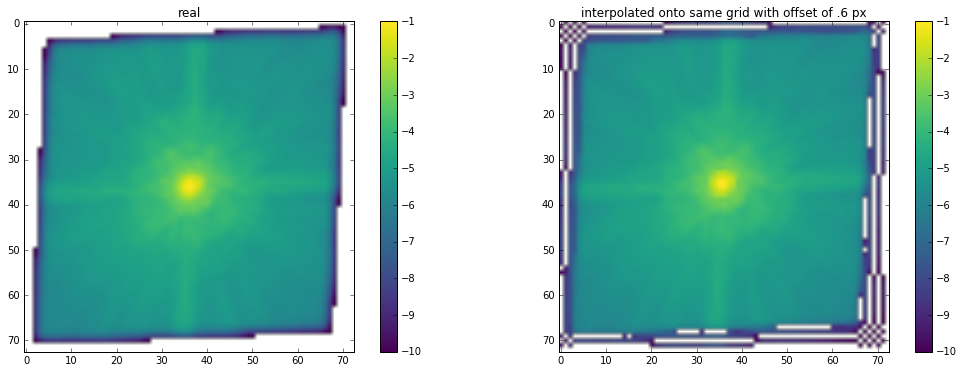

In [10]:
plt.subplot(2,2,1)
plt.imshow(np.log10(f606psf), vmin=-10, vmax=-1)
plt.title('real')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.log10(interp606(*psf_indecies+.6, grid=False)),vmin=-10, vmax=-1)
plt.title('interpolated onto same grid with offset of .6 px')
plt.colorbar()
plt.tight_layout()

In [11]:
#check that flux is reasonably conserved
np.sum(f606psf)-1,np.sum(interp606(*psf_indecies, grid=False))-1,np.sum(interp606(*psf_indecies+.6, grid=False))-1

(1.0728836059570312e-06, 1.0231127380855298e-06, 1.1177614052115814e-06)

### F814W 

In [12]:
psf_indecies814 = np.indices(f814psf.shape) - f814psf.shape[0]//2
psf_indecies814_1d = psf_indecies[1,0]

interp814 = interpolate.RectBivariateSpline(psf_indecies814_1d, psf_indecies814_1d, f606psf)

In [13]:
#check that flux is reasonably conserved
np.sum(f814psf)-1,np.sum(interp814(*psf_indecies814, grid=False))-1,np.sum(interp814(*psf_indecies814+.6, grid=False))-1

(1.7881393432617188e-06, 1.0231127380855298e-06, 1.1177614052115814e-06)

# Now create a fake image 

In [14]:
nstars = 15
poisson_scale = 15
bkg = 1
flux_scale = 2500


im = np.ones((128,128))*bkg
im_indices = np.indices(im.shape)

np.random.seed(123456789)

xs, ys = np.random.rand(2, nstars)*im.shape[0]
fluxes = (np.random.rand(nstars)+.5)*flux_scale

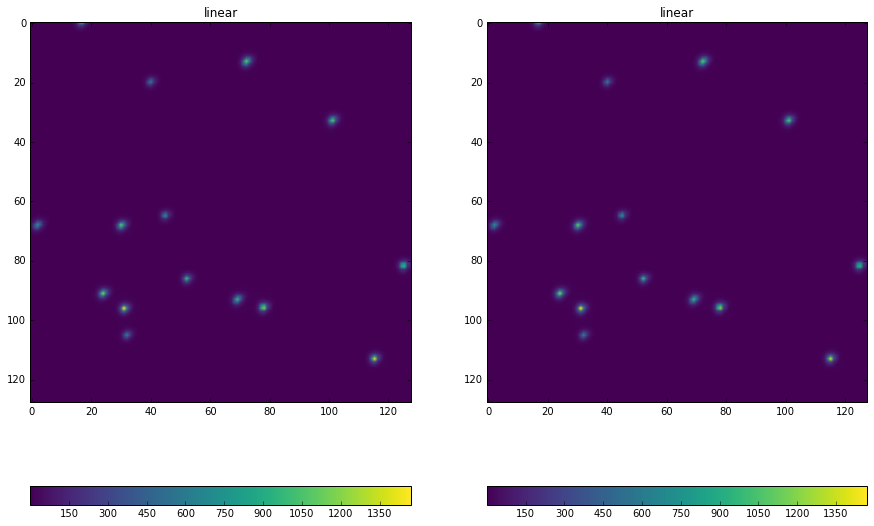

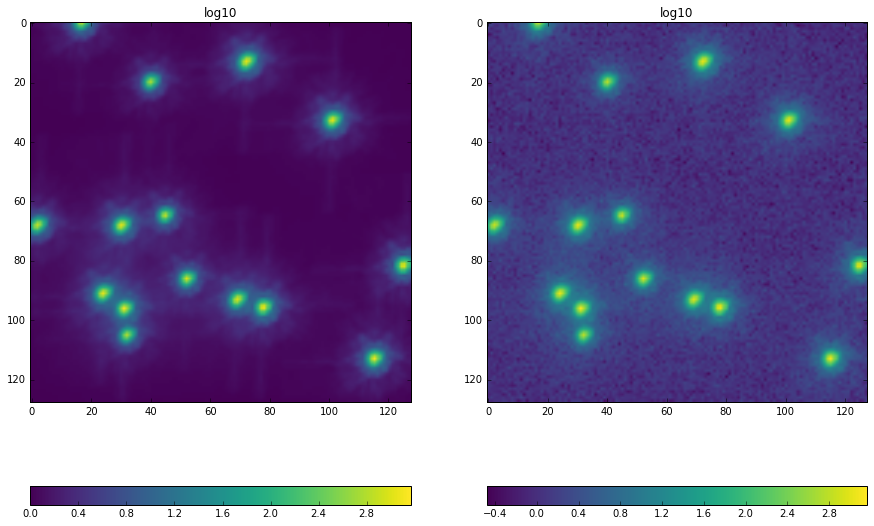

In [20]:
intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

for row in intab:
    xr = np.round(row['x_0'])
    yr = np.round(row['y_0'])
    
    i = psf_indecies814.copy().astype(float)
    i[1] += row['x_0'] - xr
    i[0] += row['y_0'] - yr
    
    toadd = interp814(*i, grid=False)
    
    ndutils.add_array(im, toadd*row['flux_0'], (xr, yr))
    
    
pim = np.random.poisson(poisson_scale*im)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(im, vmin=np.min(pim), vmax=np.max(im))
plt.title('linear')
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(pim, vmin=np.min(pim), vmax=np.max(im))
plt.title('linear')
plt.colorbar(orientation='horizontal')


plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.log10(im))
plt.title('log10')
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(np.log10(pim))
plt.title('log10')
plt.colorbar(orientation='horizontal')

# Now use the RectSplinePSF model

In [91]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
from astropy.modeling import FittableModel, Fittable2DModel
from astropy.modeling.parameters import Parameter

class RectSplinePSF(Fittable2DModel):
    dx = Parameter(description='Shift along X-axis of the PSF in '
                   'the input grid', default=0.0)
    dy = Parameter(description='Shift along Y-axis of the PSF in '
                   'the input grid', default=0.0)
    flux = Parameter(description='Flux of the resampled PSF', default=None)

    def __init__(self, psf_data, dx=dx.default, dy=dy.default,
                 flux=flux.default, order=3, fillval=0.0, centerx=0, centery=0):

        self._fillval = fillval

        # compute flux
        tdflux = np.sum(psf_data)
        if flux is None:
            flux = tdflux
        self._psf_data = psf_data / tdflux

        super(RectSplinePSF, self).__init__(dx, dy, flux)

        # set input PSF related parameters:
        self._ny, self._nx = psf_data.shape

        # define interpolating spline:
        self.set_spline_order(order)
        
        self.centerx = centerx
        self.centery = centery

    @property
    def psf_data(self):
        """
        Return normalized input PSF data such that sum of all pixels is 1.
        """
        return self._psf_data

    @property
    def psf_shape(self):
        return self._psf_data.shape

    @property
    def fillval(self):
        return self._fillval

    @fillval.setter
    def fillval(self, fillval):
        self._fillval = fillval

    def set_spline_order(self, order):
        x = np.arange(self._nx, dtype=np.float)
        y = np.arange(self._ny, dtype=np.float)
        self.psf = RectBivariateSpline(x, y, self._psf_data.T,
                                       kx=order, ky=order)

    def evaluate(self, x, y, dx, dy, flux):
        xi = x - dx + self.centerx
        yi = y - dy + self.centery

        ipsf = flux * self.psf.ev(xi, yi)

        if self._fillval is not None:
            # find indices of pixels that are outside the PSF grid and
            # set these pixels to the 'fillval':
            invalid = np.logical_or(
                np.logical_or(xi < 0, xi > self._nx - 1),
                np.logical_or(yi < 0, yi > self._ny - 1)
            )
            ipsf[invalid] = self._fillval

        return ipsf
    
    psf_xname = 'dx'
    psf_yname = 'dy'


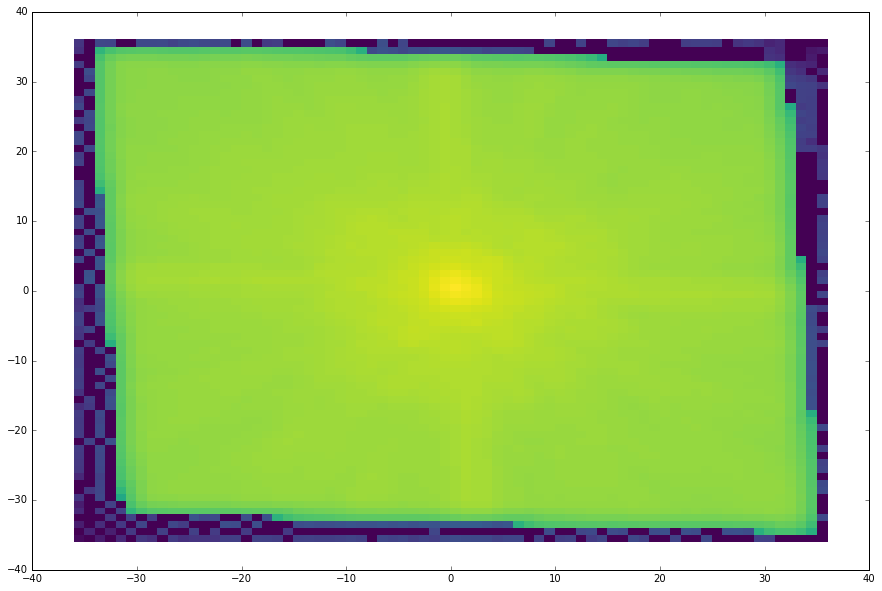

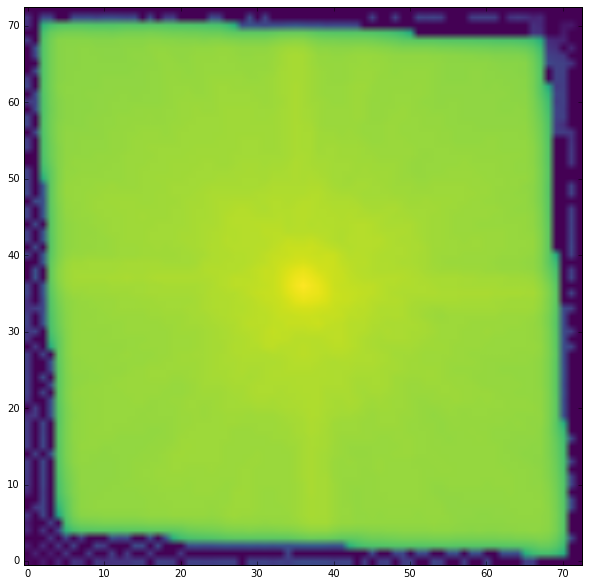

In [92]:
psf606 = RectSplinePSF(f606psf, centerx=psf_indecies.shape[2]//2, centery=psf_indecies.shape[1]//2, )
rendered = psf606.render(coords=psf_indecies)
rendered[rendered<=0] = np.inf
rendered[np.isinf(rendered)] = np.min(rendered)/5

plt.figure()
plt.pcolor(psf_indecies[1], psf_indecies[0], np.log10(rendered))

plt.figure()
plt.imshow(np.log10(rendered), origin='lower')

# Now try fitting 

In [93]:
# note that this assumes the underlying image is the same as the above
def compare_psf_sub(subim, pim, im, kw1s={}, kw2s={}, kw3s={}, kw4s={}, log=False):
    subps = (2, 2)
    cborient = 'vertical'
    
    if log:
        filt = np.log10
    else:
        filt = lambda x:x
    
    plt.subplot(*subps,1)
    plt.imshow(filt(pim), **kw1s)
    plt.colorbar(orientation=cborient)
    plt.title('Base image')

    plt.subplot(*subps,2)
    plt.imshow(filt(subim), **kw2s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF subtracted image')
    print("Subtracted image bkg-sub mean:", np.mean(subim-bkg), 'and SD:', np.std(subim-bkg))

    plt.subplot(*subps,3)
    plt.imshow(filt(im), **kw3s)
    plt.colorbar(orientation=cborient)
    plt.title('Real noise-free images')

    plt.subplot(*subps,4)
    plt.imshow(filt(pim-subim), **kw4s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF images')

/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in log10


Subtracted image bkg-sub mean: 2.57316590091 and SD: 27.5500399085


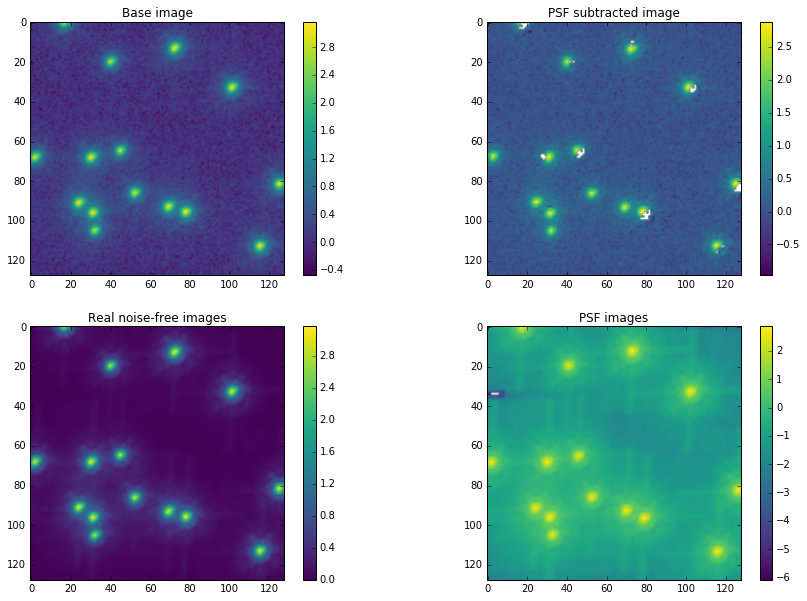

In [103]:
# this should be near-perfect psf-subtraction because it knows the positions/fluxes already
subim = psf.subtract_psf(pim, psf606, (ys, xs, fluxes))
compare_psf_sub(subim, pim, im, log=True)

Subtracted image bkg-sub mean: 5.19542643229 and SD: 45.4561171927


/Users/erik/miniconda3/envs/photutils/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


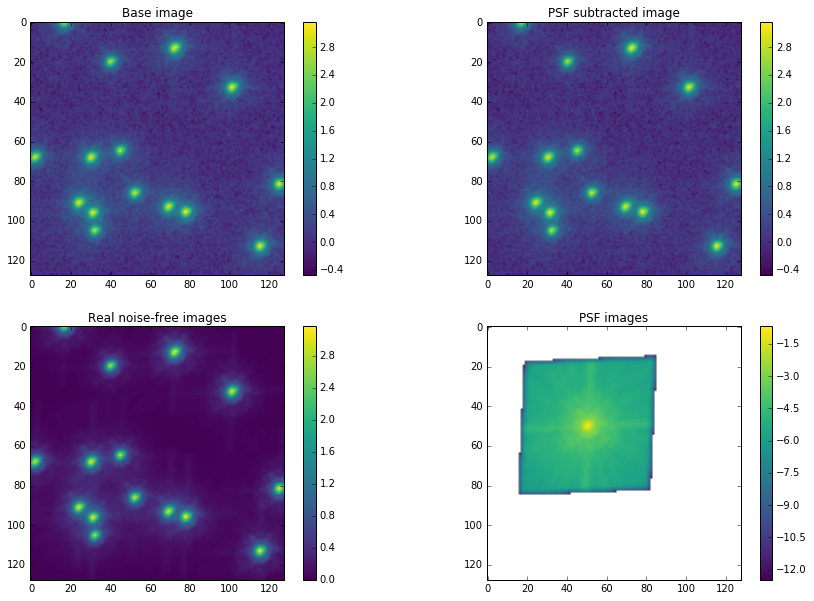

In [97]:
subim = psf.subtract_psf(pim, psf606, ([50], [50], [1]))
compare_psf_sub(subim, pim, im, log=True)